In [1]:
# Import packages
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(10, 6) # Width and hight



In [2]:
# Read the preprocessed data

# Construct the full path to the CSV file
csv_file_path_pre_processed = Path.cwd().parent / 'preprocessed_data_2.csv'
csv_file_path_raw = Path.cwd().parent / 'training_data_vt2025.csv'

# Read the CSV file using pandas
pre_processed_data = pd.read_csv(csv_file_path_pre_processed)
raw_data = pd.read_csv(csv_file_path_raw)

In [3]:
# Split the data into input values, X, and output value, y
X = pre_processed_data.drop(columns=['increase_stock'])
y = pre_processed_data['increase_stock']

In [4]:
# Stratified K-Fold Cross Validation (better for imbalanced classification problems)

def model_training(X, y, k, model):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    models = []
    classification_reports = []
    confusion_matrices = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold+1}/{k}")
        
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Scaling
        ct = ColumnTransformer([
            ('scaler', StandardScaler(), ['temp','dew', 'windspeed','day_of_week_sin', 'day_of_week_cos', 'hour_of_day_sin', 'hour_of_day_cos', 'month_sin', 'month_cos' ]),
            ('minmax', MinMaxScaler(), ['humidity', 'cloudcover']),
            ('robust', RobustScaler(), ['precip', 'snowdepth', 'visibility']),
            ('passthrough', 'passthrough', ['weekday', 'is_summer', 'holiday'])
        ], remainder='passthrough')
        X_train = ct.fit_transform(X_train)
        X_val = ct.transform(X_val)

        # Train the model
        model_1 = model
        model_1.fit(X_train, y_train)

        # Make predictions on the validation set
        #y_pred = model_1.predict(X_val)

        predict_prob = model.predict_proba(X_val)
        positive_class_index = np.argwhere(model_1.classes_ == 1).squeeze()
        y_pred = np.where(predict_prob[:, positive_class_index] > 0.38, 1, 0)

        # Evaluate the model
        accuracy = accuracy_score(y_val, y_pred)
        accuracies.append(accuracy)

        report = classification_report(y_val, y_pred, output_dict=True) 
        classification_reports.append(report)

        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        models.append(model_1)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    results = {
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'models': models,
        'classification_reports': classification_reports,
        'confusion_matrices': confusion_matrices
    }

    return results

In [5]:
n_folds = 5

results = model_training(X, y, n_folds, LinearDiscriminantAnalysis())

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [6]:
print(f"Mean Accuracy: {results['mean_accuracy']:.4f}")
print(f"Standard Deviation of Accuracy: {results['std_accuracy']:.4f}")

Mean Accuracy: 0.8575
Standard Deviation of Accuracy: 0.0139


In [7]:
f1_scores = []
for i in range(n_folds):
    f1_scores.append(results['classification_reports'][i]['weighted avg']['f1-score'])

In [8]:
mean_f1_score = np.mean(f1_scores)
mean_f1_score

0.8600720214569673

In [9]:
results['classification_reports'][0]

{'0': {'precision': 0.9314516129032258,
  'recall': 0.8783269961977186,
  'f1-score': 0.9041095890410958,
  'support': 263.0},
 '1': {'precision': 0.5555555555555556,
  'recall': 0.7017543859649122,
  'f1-score': 0.6201550387596899,
  'support': 57.0},
 'accuracy': 0.846875,
 'macro avg': {'precision': 0.7435035842293907,
  'recall': 0.7900406910813154,
  'f1-score': 0.7621323139003928,
  'support': 320.0},
 'weighted avg': {'precision': 0.864495127688172,
  'recall': 0.846875,
  'f1-score': 0.8535301847722204,
  'support': 320.0}}

In [10]:
results['confusion_matrices'][0]

array([[231,  32],
       [ 17,  40]], dtype=int64)

Text(0, 0.5, 'True positive rate')

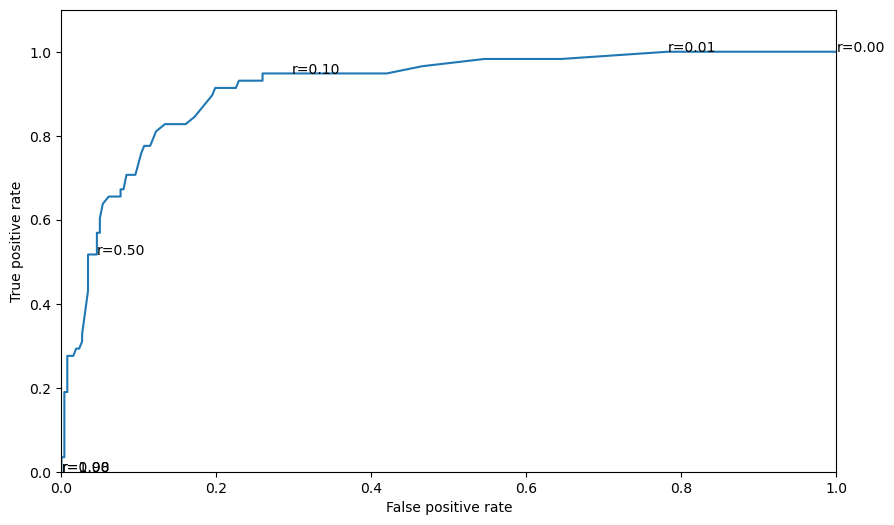

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

true_positive_rate = []
false_positive_rate = []

positive_class = 1
negative_class = 0

P = np.sum(y_test == positive_class)
N = np.sum(y_test == negative_class)

threshold = np.linspace(0.00, 1, 101)
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)
predict_prob = model.predict_proba(X_test)
positive_class_index = np.argwhere(model.classes_ == positive_class).squeeze()

for r in threshold:
    prediction = np.where(predict_prob[:, positive_class_index] > r, positive_class, negative_class)

    FP = np.sum((prediction == positive_class) & (y_test == negative_class))
    TP = np.sum((prediction == positive_class) & (y_test == positive_class))

    false_positive_rate.append(FP/N)
    true_positive_rate.append(TP/P)

plt.plot(false_positive_rate, true_positive_rate)
for idx in [0, 1, 10, 50, 98, 100]:
    plt.text(false_positive_rate[idx], true_positive_rate[idx], f"r={threshold[idx]:.2f}")
plt.xlim([0,1])
plt.ylim([0,1.1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')